# K Means Clustering

## Loading the Spark Context with all the imports

In [614]:
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
from pyspark import SparkContext
import os.path
import numpy as np
dir_name = '<Enter project location here>'
bank_additional_csv = os.path.join(dir_name, 'dataset', 'bank-additional', 'bank-additional.csv')
sc_context = SparkContext(appName='bankLoanAnalysis')

<p>After the spark context is loaded the data frame is read. And the labels are converted to numerical type. 

Numerical Columns are extracted from the dataset</p>

In [631]:
df = pd.read_csv(bank_additional_csv, delimiter=';')

labels = df[['y']].values
for index in range(df.shape[0]):
    labels[index][0] = 1 if labels[index][0]=='yes' else 0
data = df[['age',
                'duration',
                'campaign',
                'pdays',
                'previous',
                'emp.var.rate',
                'cons.price.idx',
                'cons.conf.idx',
                'euribor3m',
                'nr.employed']].values

<h1>Heat map of the feature matrix</h1>


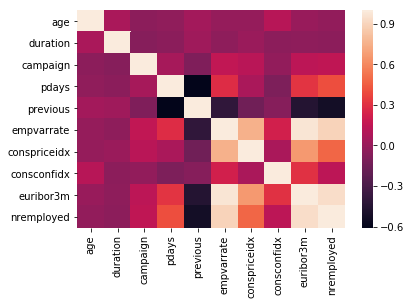

In [630]:
from pyspark.sql import SQLContext
from pyspark.sql.types import *
sql_context = SQLContext(sc_context)
schema = StructType([
    StructField('age', DoubleType(), True),
    StructField('job', StringType(), True),
    StructField('martial', StringType(), True),
    StructField('education', StringType(), True),
    StructField('default', StringType(), True),
    StructField('hosting', StringType(), True),
    StructField('loan', StringType(), True),
    StructField('contact', StringType(), True),
    StructField('month', StringType(), True),
    StructField('day_of_week', StringType(), True),
    StructField('duration', DoubleType(), True),
    StructField('campaign', DoubleType(), True),
    StructField('pdays', DoubleType(), True),
    StructField('previous', DoubleType(), True),
    StructField('p_outcome', StringType(), True),
    StructField('empvarrate', DoubleType(), True),
    StructField('conspriceidx', DoubleType(), True),
    StructField('consconfidx', DoubleType(), True),
    StructField('euribor3m', DoubleType(), True),
    StructField('nremployed', DoubleType(), True),
    StructField('y', StringType(), True)])

numeric_cols = ['age',
                'duration',
                'campaign',
                'pdays',
                'previous',
                'empvarrate',
                'conspriceidx',
                'consconfidx',
                'euribor3m',
                'nremployed']
categorical_cols = ['job',
                    'martial',
                    'education',
                    'default',
                    'hosting',
                    'loan',
                    'contact',
                    'month',
                    'day_of_week',
                    'p_outcome']
dir_name = '/home/dennis/Documents/Cloud\ Computing/Project/Spark_Linear_Regression/'
churn_data = sql_context.read\
    .format('com.databricks.spark.csv')\
    .load(os.path.join(dir_name, 'dataset', 'bank-additional', 'bank-additional.csv'),
          schema=schema)

sample_data = churn_data.sample(False, 0.5, 83).toPandas()
corr = sample_data[numeric_cols].corr()
heat_map = sb.heatmap(corr)
plt.show(heat_map)

<h1>Normalization of the dataset</h1>
<p>
Two kinds of Normalization is compared - 
<ol><i><b><h3>1. (x * mean / variance)</h3></b></i></ol> 
<ol>&nbsp;- This creates values that are about the mean and has a variance that is mentioned in the formula.</ol>
<ol><i><b><h3>2. (x - min)/(max-min)</h3></b></i></ol> 
<ol>&nbsp;- This creates values of the range between 0 - 1. This leads to values that are scaled down and the variance between the samples are greatly reduced. And this is not ideal for k-means. But it is one of the methods followed in this implementation to showcase the importance of normalization using the right method.</ol>
</p>

In [510]:
number_of_rows, number_of_features = data.shape


In [587]:
unnorm_rdd = sc_context.parallelize(data)
unnorm_rdd.collect()

[array([  3.00000000e+01,   4.87000000e+02,   2.00000000e+00,
          9.99000000e+02,   0.00000000e+00,  -1.80000000e+00,
          9.28930000e+01,  -4.62000000e+01,   1.31300000e+00,
          5.09910000e+03]),
 array([  3.90000000e+01,   3.46000000e+02,   4.00000000e+00,
          9.99000000e+02,   0.00000000e+00,   1.10000000e+00,
          9.39940000e+01,  -3.64000000e+01,   4.85500000e+00,
          5.19100000e+03]),
 array([  2.50000000e+01,   2.27000000e+02,   1.00000000e+00,
          9.99000000e+02,   0.00000000e+00,   1.40000000e+00,
          9.44650000e+01,  -4.18000000e+01,   4.96200000e+00,
          5.22810000e+03]),
 array([  3.80000000e+01,   1.70000000e+01,   3.00000000e+00,
          9.99000000e+02,   0.00000000e+00,   1.40000000e+00,
          9.44650000e+01,  -4.18000000e+01,   4.95900000e+00,
          5.22810000e+03]),
 array([  4.70000000e+01,   5.80000000e+01,   1.00000000e+00,
          9.99000000e+02,   0.00000000e+00,  -1.00000000e-01,
          9.32000000

Max_val, sum_val, min_val and count_val are used to calculate the variance and mean of the distribution which is then used to normalize the dataset into norm2_rdd. 

In [512]:
max_val = unnorm_rdd.map(lambda each_value: ('_', each_value)).reduceByKey(lambda var1, var2: np.maximum(var1,var2)).reduce(lambda var: var)[1]
max_val


array([  8.80000000e+01,   3.64300000e+03,   3.50000000e+01,
         9.99000000e+02,   6.00000000e+00,   1.40000000e+00,
         9.47670000e+01,  -2.69000000e+01,   5.04500000e+00,
         5.22810000e+03])

In [513]:
sum_val = unnorm_rdd.map(lambda each_value: ('_', each_value)).reduceByKey(lambda var1, var2: np.add(var1,var2)).reduce(lambda var: var)[1]
sum_val

array([  1.65228000e+05,   1.05771000e+06,   1.04510000e+04,
         3.95597900e+06,   7.84000000e+02,   3.50000000e+02,
         3.85454802e+05,  -1.66815800e+05,   1.49163640e+04,
         2.12807381e+07])

In [514]:
min_val = unnorm_rdd.map(lambda each_value: ('_', each_value)).reduceByKey(lambda var1, var2: np.minimum(var1,var2)).reduce(lambda var: var)[1]
min_val

array([  1.80000000e+01,   0.00000000e+00,   1.00000000e+00,
         0.00000000e+00,   0.00000000e+00,  -3.40000000e+00,
         9.22010000e+01,  -5.08000000e+01,   6.35000000e-01,
         4.96360000e+03])

In [515]:
count_val = unnorm_rdd.map(lambda each_value: ('_', 1)).reduceByKey(lambda var1, var2: var1+var2).reduce(lambda var:var)[1]
count_val

4119

In [516]:
norm_rdd = unnorm_rdd.map(lambda each_value: (each_value-min_val)/(max_val-min_val))
norm_data = np.array(norm_rdd.collect())
norm_data.shape

(4119, 10)

In [517]:
avg_val = sum_val/count_val
avg_val

array([  4.01136198e+01,   2.56788055e+02,   2.53726633e+00,
         9.60422190e+02,   1.90337461e-01,   8.49720806e-02,
         9.35797043e+01,  -4.04991017e+01,   3.62135567e+00,
         5.16648169e+03])

In [518]:
norm2_rdd = unnorm_rdd.map(lambda each_value: each_value - (sum_val/count_val))
variance_val = norm2_rdd.map(lambda each_value: ('_', each_value**2)).reduceByKey(lambda var1, var2: np.add(var1, var2))
variance_val = variance_val.reduce(lambda each_value : each_value/count_val)[1]
norm2_rdd = norm2_rdd.map(lambda each_value: each_value/variance_val)
norm2_rdd.collect()

[array([ -2.30897801e-05,   8.61729341e-07,  -1.97815074e-05,
          2.54330328e-07,  -1.57463045e-04,  -1.87342806e-04,
         -4.96824715e-04,  -6.55791503e-05,  -1.86518959e-04,
         -3.01508087e-06]),
 array([ -2.54243653e-06,   3.33938147e-07,   5.38561148e-05,
          2.54330328e-07,  -1.57463045e-04,   1.00881165e-04,
          2.99739415e-04,   4.71532020e-05,   9.96805042e-05,
          1.09710321e-06]),
 array([ -3.45049709e-05,  -1.11502647e-07,  -5.66003185e-05,
          2.54330328e-07,  -1.57463045e-04,   1.30697437e-04,
          6.40503907e-04,  -1.49646248e-05,   1.08326281e-04,
          2.75719058e-06]),
 array([ -4.82547470e-06,  -8.97574638e-07,   1.70373037e-05,
          2.54330328e-07,  -1.57463045e-04,   1.30697437e-04,
          6.40503907e-04,  -1.49646248e-05,   1.08083876e-04,
          2.75719058e-06]),
 array([  1.57218688e-05,  -7.44103440e-07,  -5.66003185e-05,
          2.54330328e-07,  -1.57463045e-04,  -1.83839267e-05,
         -2.74712827

In [519]:
variance_val

array([  4.38012826e+05,   2.67151104e+08,   2.71600296e+04,
         1.51683877e+08,   1.20877543e+03,   1.00616198e+04,
         1.38218627e+03,   8.69315667e+04,   1.23759841e+04,
         2.23482213e+07])

In [520]:
def get_distance(data_point, cluster_point):
    '''
    The distance between two points are returned. Both are expected to be numpy arrays
    '''
    return np.linalg.norm(data_point-cluster_point)

In [521]:
def is_empty(arr):
    '''
    Checks if the passed numpy array is empty. The argument has to be a numpy array.
    '''
    return arr.size == 0

In [522]:
def add_data_point_to_members(data_point, members):
    '''
    Each data_point is appended into its members numpy array.
    '''
    if is_empty(members):
        members = np.concatenate((members, data_point), axis=1)
    else:
        members = np.concatenate((members, data_point), axis=0)
    return members

In [523]:
def get_cluster_members(data_point, cluster_point1, cluster_point2):
    '''
    It assigns the data point to the cluster_members numpy array based on which cluster point it is closest to.
    '''
    global c1_members, c2_members
    d1 = get_distance(data_point, cluster_point1)
    d2 = get_distance(data_point, cluster_point2)
    if d1 < d2:
        c1_members = add_data_point_to_members(data_point, c1_members)
    else:
        c2_members = add_data_point_to_members(data_point, c2_members)
    return c1_members, c2_members

<h1>Cluster Initialization</h1>
<p> There are different ways of doing cluster initialization.<i>
<ol>1. Random Initialization</ol>
<ol>2. Random Initialization about the mean</ol>
<ol>3. Random Initialization about the mean of two partitions</ol>
<ol>4. Random Initialization about the individual attribute values</ol>
</i>
<br><b>Random Initialization: </b> This leads to one of the clusters moving to outliers and so it is not used in our method.
<br><br><b>Random Initialization about the mean: </b> Although this appears to perform better in theory for our dataset this methodology did not perform well.
<br><br><b>Random Initialization about the mean of two partitions: </b> This is the method followed in this code and it is consistent.
</p>


In [639]:
def get_initial_clusters(data_points):
    '''
    Two clusters are initiated. 
    It is created by shuffling the datapoints in the set and then partitioning it into two.
    Then the mean of two partitions are the initiated numpy arrays. 
    Pros: Avoids outliers and injects consistency in the solution.
    Cons: If the testset is large then the partitions are themselves large and the initiation set has a huge cost.
    '''
    _, number_of_features = data_points.shape
    from sklearn.model_selection import train_test_split
    o1, o2 = train_test_split(data_points, test_size = 0.5)
    return np.mean(o1, axis=0).reshape(1, number_of_features), np.mean(o2, axis=0).reshape(1, number_of_features)

In [525]:
def calculate_loss(members, cluster):
    '''
    The loss is the sum of the distances between the passed numpy array and the members.
    '''
    loss = 0
    for each_member in members:
        loss += get_distance(each_member, cluster)
    return loss

In [526]:
def get_loss_value(cluster_point1, cluster_point2, c1_members, c2_members):
    '''
    This function returns the total cost of both the clusters with its associated members.
    '''
    return calculate_loss(c1_members, cluster_point1) + calculate_loss(c1_members, cluster_point1)

In [654]:
def kmeans(data, cutoff=5):
    '''
    This function has the value of K to be implicitly two.
    '''
    global c1_members, c2_members
    
    number_of_features = data.shape[1]
    c1_members = np.array([[]])
    c2_members = np.array([[]])
    matched = False

    # Cluster Initiation Step
    c1, c2 = get_initial_clusters(data)
    loss = None

    # Loop exits after 1000 iterations even if it does not converge
    for i in range(1,1000):    
        c1_members = np.array([[]])
        c2_members = np.array([[]])

        # Member Assignment Step
        for each_data_point in data:
            c1_members, c2_members = get_cluster_members(each_data_point.reshape(1, number_of_features), c1, c2)

        # Cluster update Step
        c1 = np.mean(c1_members, axis=0)
        c2 = np.mean(c2_members, axis=0)

        # Check for loop
        if loss is None:
            loss = get_loss_value(c1, c2, c1_members, c2_members)
        else:
            current_loss = get_loss_value(c1, c2, c1_members, c2_members)
            if loss == current_loss:
                if matched is True:
                    cutoff -= 1
                else:
                    cutoff += 1
                matched = True
            else:
                matched = False
            loss = current_loss
        if cutoff <= 0:
            break

#         print('Loss at iteration '+str(i)+ ' is '+str(loss))
    return c1, c2, loss

In [660]:
norm2_data = np.array(norm2_data)
loss_val = 0
for i in range(10):
    _,_, l_temp = kmeans(data=norm2_data)
    loss_val+= l_temp
loss_val/3

4.0433401884235405

In [661]:
norm_data = np.array(norm_data)
loss_val = 0
for i in range(10):
    _,_, l_temp = kmeans(data=norm_data)
    loss_val+= l_temp
loss_val/3

4831.1197224034377

<h1>Feature Selection</h1>
Highly correlated Features are removed and the loss has not decreased as much for kmeans even though there is an increase in accuracy with Logistic Regression.

In [662]:
loss_val = 0
for i in range(10):
    _,_, l_temp = kmeans(data=norm2_data[:,:8])
    loss_val+= l_temp
loss_val/3

4.5026341325049994

<h1>Scatter Plot</h1>
The diagram below shows that norm2_data has more variance and so it is more easy to find patterns

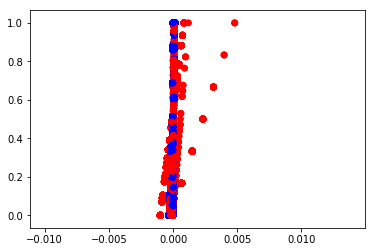

In [613]:
colors = np.random.rand(2)
plot = plt.scatter(norm2_data, norm_data, c = ['red', 'blue'])
plt.show(plot)

<h1>Conclusion</h1>
From the K-means implementation it is deduced that feature selection is very important to reduce the loss incurred when finding clusters and initialization of the clusters largly determine the success or failure of the algorithm. The general rule is to make sure that the clusters and not influenced by the outliers and all other design decisions are made with this in mind. In our analysis, feature selection by using correlation between the values did not reduce the loss value. Overall in terms of labels, no structure was found to be correlated between labels and its data.